# Imports

In [1]:
# We start by loading the libraries we're going to use.
import json
import numpy as np
import matplotlib.pyplot as plt

# Folium-package for creating maps and overlays on maps.
import folium, json

# Pandas is an alternative to numpy, using dataframes instead of array, great overview of matrixes.
import pandas as pd

# Statsmodels.api are used for making a multivariable regression or analysis i Task 4.  
import statsmodels.api as sm

# Scipy.stats we use for calculating Pearson and Spearman correlations and p-values. 
from scipy.stats import pearsonr, spearmanr

# Seaborn are used for making plots, in this case heatmapping dataframes.
import seaborn as sns

# Constants

In [2]:
# Extracted from the de_metadata.json
population_map={'DE-BW': 11069533, 'DE-BY': 13076721, 'DE-BE': 3644826, 'DE-BB': 2511917, 'DE-HB': 682986, 
 'DE-HH': 1841179, 'DE-HE': 6265809, 'DE-NI': 7982448, 
 'DE-MV': 1609675, 'DE-NW': 17932651, 'DE-RP': 4084844, 'DE-SL': 990509, 
 'DE-SN': 4077937, 'DE-ST': 2208321, 'DE-SH': 2896712, 'DE-TH': 2143145}

region_dic2={'Baden-Württemberg': 'DE-BW', 'Bayern': 'DE-BY', 'Berlin': 'DE-BE', 'Brandenburg': 'DE-BB',
 'Bremen': 'DE-HB', 'Hamburg': 'DE-HH', 'Hessen': 'DE-HE', 'Niedersachsen': 'DE-NI', 'Mecklenburg-Vorpommern': 'DE-MV',
 'Nordrhein-Westfalen': 'DE-NW', 'Rheinland-Pfalz': 'DE-RP', 
 'Saarland': 'DE-SL', 'Sachsen': 'DE-SN', 'Sachsen-Anhalt': 'DE-ST', 'Schleswig-Holstein': 'DE-SH', 'Thüringen': 'DE-TH'}

region_dic={"DE-BW":"Baden-Württemberg","DE-BY":"Bayern","DE-BE":"Berlin","DE-BB":"Brandenburg","DE-HB":"Bremen","DE-HH":"Hamburg","DE-HE":"Hessen",
           "DE-MV":"Mecklenburg-Vorpommern","DE-NI":"Niedersachsen","DE-NW":"Nordrhein-Westfalen","DE-RP":"Rheinland-Pfalz","DE-SL":"Saarland",
            "DE-SN":"Sachsen","DE-ST":"Sachsen-Anhalt","DE-SH":"Schleswig-Holstein","DE-TH":"Thüringen"}

Index = ["Baden-Württemberg","Bayern","Berlin","Brandenburg","Bremen","Hamburg","Hessen","Mecklenburg-Vorpommern","Niedersachsen",
                               "Nordrhein-Westfalen","Rheinland-Pfalz","Saarland","Sachsen","Sachsen-Anhalt","Schleswig-Holstein","Thüringen"]

In [3]:
# Extracting the data from the csv and geojson files
geo_json_path = "../data/raw/shapefiles/de.geojson"

weather_df = pd.read_csv("../data/raw/weather/weather.csv", sep = "\t")
weather_df2 = pd.read_csv("../data/raw/weather/weather2.csv", sep = "\t")
corona_df = pd.read_csv("../data/raw/corona/de_corona.csv", sep = "\t")

# Changing the name of the two columns
corona_df = corona_df.rename(columns={'confirmed_addition': 'CASES', 'deceased_addition': 'deaths'})

with open("../data/raw/metadata/de_metadata.json", 'r') as f:
    country_metadata = json.load(f)

# Appending the dataset to the old weather dataset
weather = weather_df.append(weather_df2)

# The second weather dataset contains also weather data from DK, to solve this it was used a masked that searches for the regions that start with DE
s_weather = weather["iso3166-2"].astype(str)
mask_not_de= s_weather.str.startswith('DE')
weather= weather[mask_not_de]

weather["iso3166-2"]=weather["iso3166-2"].map(region_dic)
weather = weather.rename(columns={"iso3166-2":"region_code"})
print(weather["region_code"])

# Exploring the datasets to see if there are any missing values and also the number of rows and type of the vairables
weather.info()
corona_df.info()
print(corona_df["region_code"].value_counts())
weather["region_code"].value_counts()

# Seeing how the first 10 rows in the dataframe look
corona_df.head(10)

0              Brandenburg
1                   Berlin
2        Baden-Württemberg
3                   Bayern
4                   Bremen
               ...        
2044    Schleswig-Holstein
2045              Saarland
2046               Sachsen
2047        Sachsen-Anhalt
2048             Thüringen
Name: region_code, Length: 6000, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 2048
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     6000 non-null   object 
 1   region_code              6000 non-null   object 
 2   RelativeHumiditySurface  6000 non-null   float64
 3   SolarRadiation           6000 non-null   float64
 4   Surfacepressure          6000 non-null   float64
 5   TemperatureAboveGround   6000 non-null   float64
 6   Totalprecipitation       6000 non-null   float64
 7   UVIndex                  6000 non-null   float64
 8   WindS

,date,region_code,CASES,deaths
0,2020-01-02,Nordrhein-Westfalen,1,0
1,2020-01-07,Nordrhein-Westfalen,1,0
2,2020-01-09,Nordrhein-Westfalen,1,1
3,2020-01-12,Nordrhein-Westfalen,1,0
4,2020-01-14,Nordrhein-Westfalen,1,0
5,2020-01-19,Berlin,1,0
6,2020-01-23,Saarland,1,0
7,2020-01-25,Nordrhein-Westfalen,1,0
8,2020-01-28,Bayern,2,0
9,2020-01-29,Bayern,2,0


In [4]:
import datetime
# Weather dataset and corona dataset merged by date and region
data_merged = pd.merge(corona_df,weather,how='inner',on=["date","region_code"])

#Adding seven days to the date, this means that the number of cases at a certain date is the number of people that got infected 7 days ago 
#Also the weather data on a certain date is from 7 days ago,so for example the weather conditions from 02-16-2020 have been moved to 02-23-2020
data_merged_delay=data_merged.copy()
data_merged_delay['date'] = data_merged_delay.apply(lambda x: datetime.datetime.strptime(x['date'], '%Y-%m-%d'), axis=1)
data_merged_delay["date"] = data_merged_delay["date"] + pd.DateOffset(days=7)

# Dividing the uv index by 12 because in average there are around 12 hours of sun
data_merged_delay["UVIndex"]= data_merged_delay["UVIndex"]/12

# Getting the tempearture in Celcius
data_merged_delay["TemperatureAboveGround"] =data_merged_delay["TemperatureAboveGround"] -273.15

print(data_merged_delay.head(20))
data_merged.head(20)

         date             region_code  CASES  deaths  RelativeHumiditySurface  \
0  2020-02-23  Mecklenburg-Vorpommern      1       0                69.818665   
1  2020-02-24             Brandenburg      1       0                64.189273   
2  2020-02-25             Brandenburg      1       0                71.904630   
3  2020-02-27     Nordrhein-Westfalen      1       0                81.738535   
4  2020-03-02       Baden-Württemberg      1       0                80.314208   
5  2020-03-03       Baden-Württemberg      2       0                78.675310   
6  2020-03-03             Brandenburg      1       0                75.394159   
7  2020-03-04       Baden-Württemberg      4       0                81.445764   
8  2020-03-04     Nordrhein-Westfalen      3       0                88.912437   
9  2020-03-05       Baden-Württemberg      3       0                83.948059   
10 2020-03-05                  Bayern      1       0                79.941348   
11 2020-03-05     Nordrhein-

,date,region_code,CASES,deaths,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-16,Mecklenburg-Vorpommern,1,0,69.818665,4.562424e+04,2.392858e+06,284.294049,0.004641,0.211216,7.888859
1,2020-02-17,Brandenburg,1,0,64.189273,9.007504e+05,2.409194e+06,282.312595,0.001005,2.631685,6.319781
2,2020-02-18,Brandenburg,1,0,71.904630,4.042940e+06,2.421421e+06,279.679468,0.002388,4.037911,6.150824
3,2020-02-20,Nordrhein-Westfalen,1,0,81.738535,1.064802e+06,2.383996e+06,279.663867,0.006802,3.524003,6.477330
4,2020-02-24,Baden-Württemberg,1,0,80.314208,6.604918e+05,2.308155e+06,281.894530,0.005284,5.613589,4.663207
5,2020-02-25,Baden-Württemberg,2,0,78.675310,7.231482e+05,2.276181e+06,279.777256,0.008104,5.230876,6.260114
6,2020-02-25,Brandenburg,1,0,75.394159,3.458872e+06,2.371365e+06,280.662527,0.002096,4.854130,5.420213
7,2020-02-26,Baden-Württemberg,4,0,81.445764,2.721533e+06,2.272776e+06,274.491409,0.008252,5.680148,6.446453
8,2020-02-26,Nordrhein-Westfalen,3,0,88.912437,1.095179e+06,2.346243e+06,275.363591,0.008696,4.320712,5.051093
9,2020-02-27,Baden-Württemberg,3,0,83.948059,7.570487e+05,2.271955e+06,274.391182,0.012448,6.183730,6.175576


# Task 1 - Single Variable Analysis

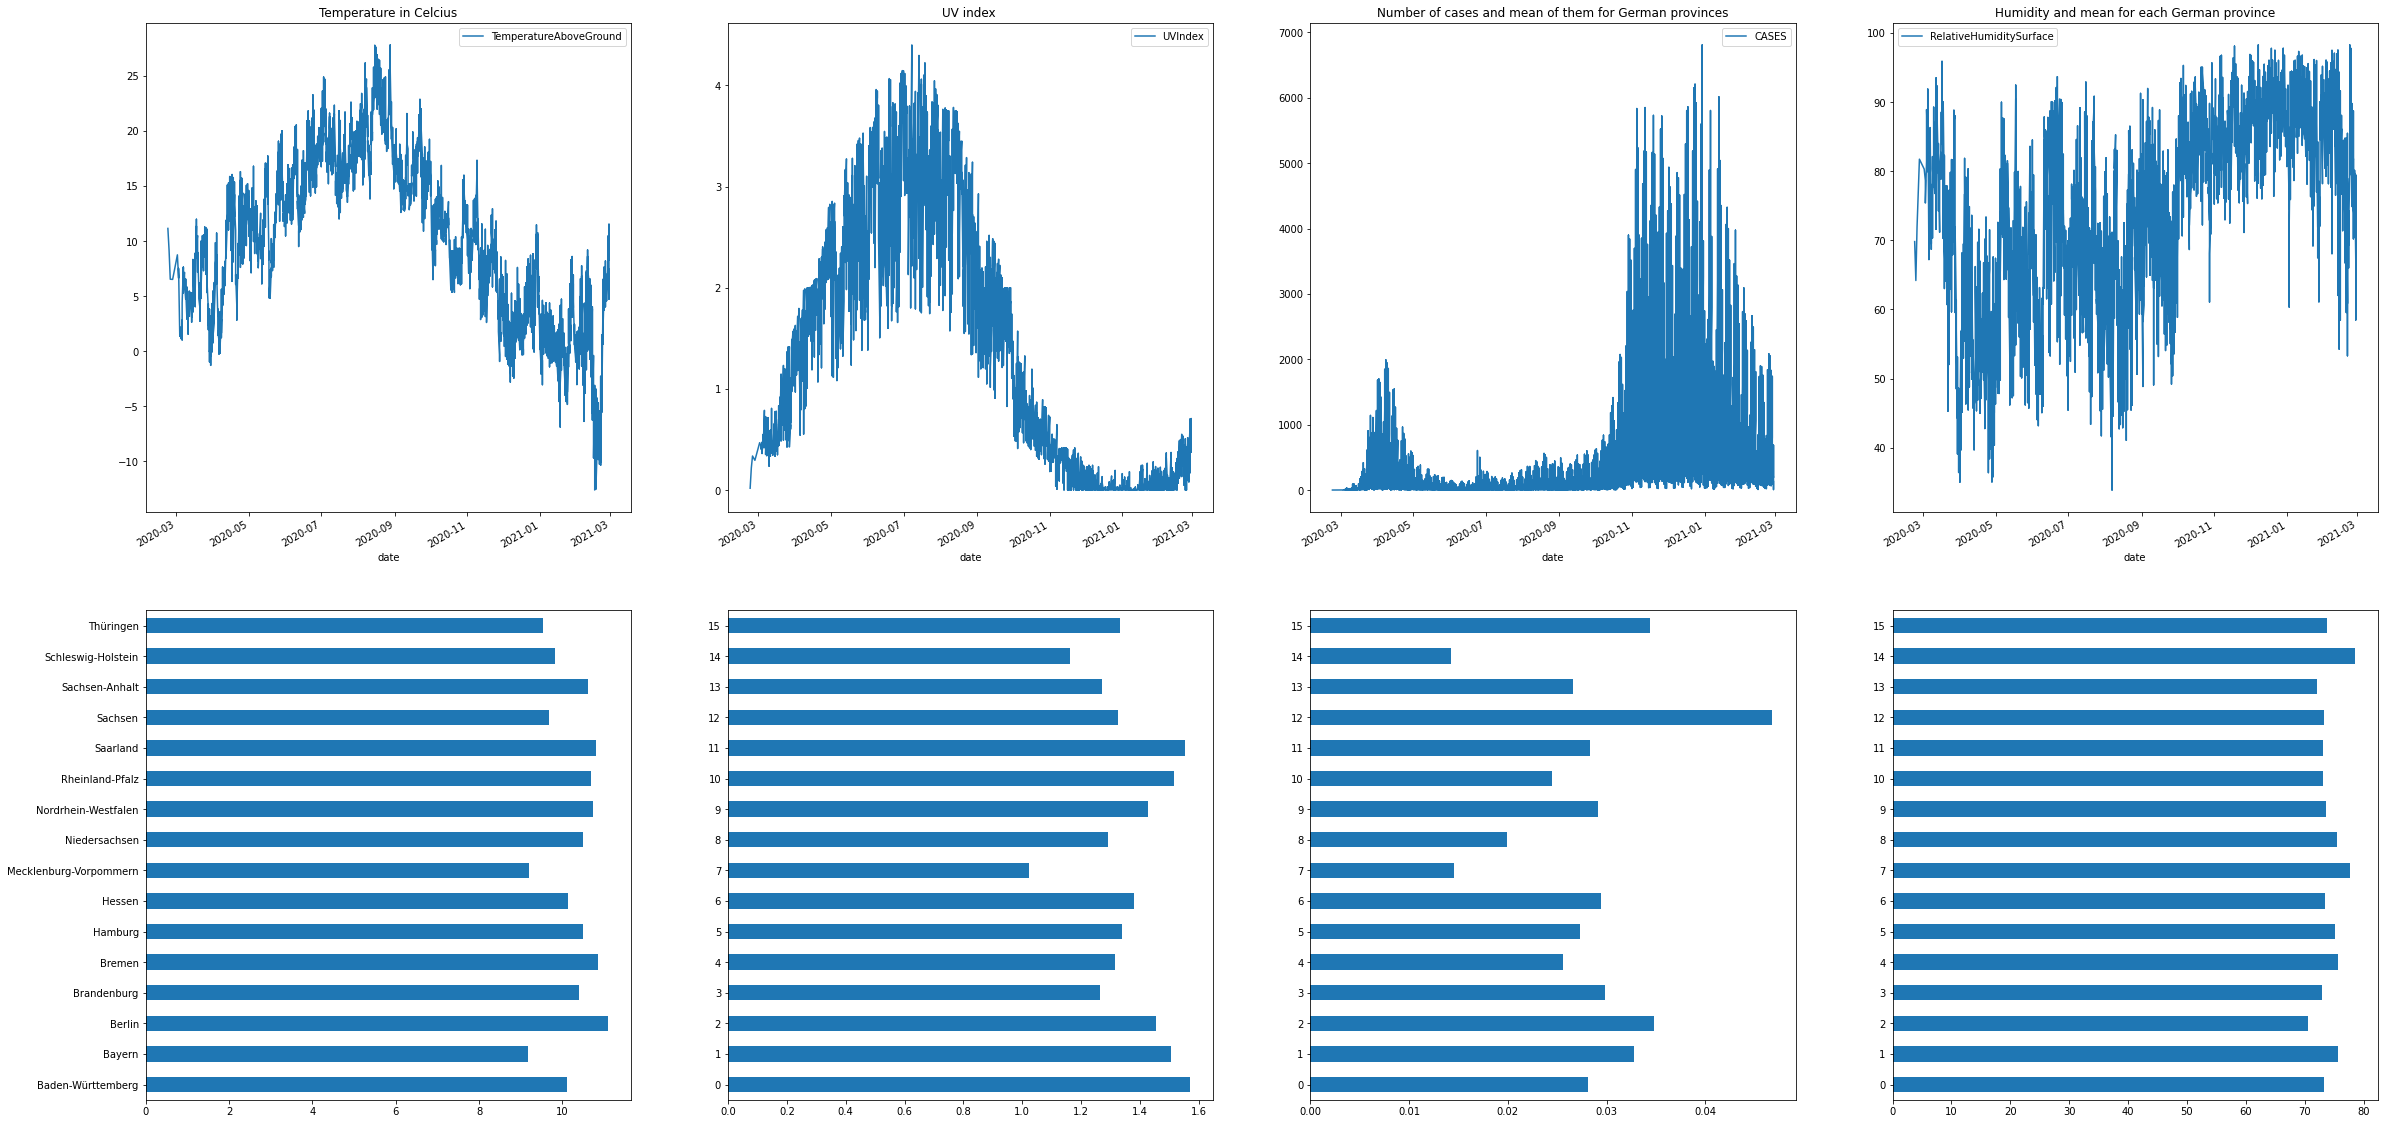

In [5]:
mean_temperature_list=[]
uvindex_list=[]
mean_nr_cases_list=[]
mean_humidity_list=[]

# Getting the mean of the variables over a certain region and then add it to a list 
for p in region_dic.items():
    data_merged_region=data_merged_delay.loc[data_merged_delay["region_code"]==p[1]]
    mean_temperature = data_merged_region["TemperatureAboveGround"].mean()
    mean_uv_index = data_merged_region["UVIndex"].mean()
    mean_number_cases = data_merged_region["CASES"].sum()/population_map[p[0]]
    mean_humidity= data_merged_region["RelativeHumiditySurface"].mean()
    uvindex_list.append(mean_uv_index)
    mean_temperature_list.append(mean_temperature)
    mean_nr_cases_list.append(mean_number_cases)
    mean_humidity_list.append(mean_humidity)
    
# Use the lists to create a dataframe
weather_data_region = {
        'Mean Temperature': mean_temperature_list,
        "Mean UVIndex": uvindex_list,
        "Mean CASES": mean_nr_cases_list,
        "Mean Humidity": mean_humidity_list
        }
# Plotting the dataframe 
weather_data_region = pd.DataFrame(weather_data_region, columns = ["Mean Temperature","Mean UVIndex","Mean CASES","Mean Humidity"],index = Index)  
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(40,22))

# For single variable analysis over a period of time
data_merged_delay.plot(x="date",y="TemperatureAboveGround",ax=ax1,title="Temperature in Celcius")
data_merged_delay.plot(x="date",y="UVIndex",ax=ax2,title="UV index ")
data_merged_delay.plot(x="date",y="CASES",ax=ax3,title="Number of cases and mean of them for German provinces")
data_merged_delay.plot(x="date",y="RelativeHumiditySurface",ax=ax4,title="Humidity and mean for each German province")

# For single variable analysis over different regions of Germany
weather_data_region["Mean Temperature"].plot(ax=ax5, kind='barh')
weather_data_region["Mean UVIndex"].plot(ax=ax6, kind='barh',use_index=False)
weather_data_region["Mean CASES"].plot(ax=ax7, kind='barh',use_index=False)
weather_data_region["Mean Humidity"].plot(ax=ax8,kind='barh',use_index=False)

plt.show()

# Task 2 - Associations

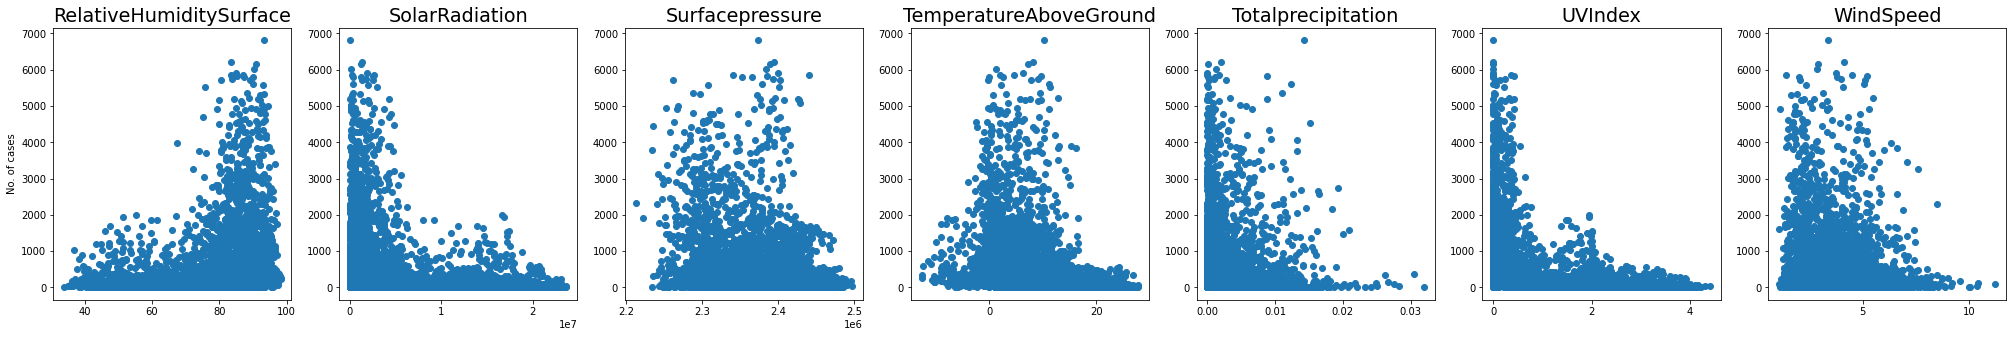

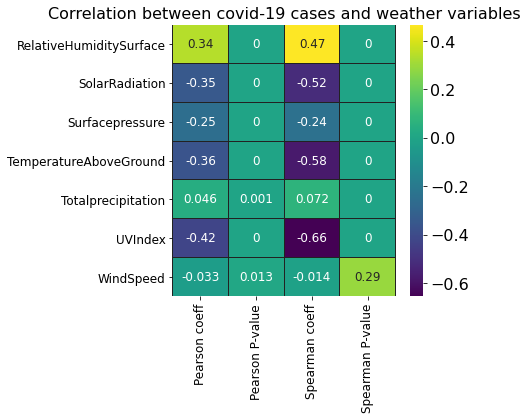

In [6]:
# Variables we want to check for associations with covid-19 cases
var_names = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 
             'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed']

# Creating a data frame of pearson and spearman coefficients and corresponding p-values
col_names = ["Pearson coeff", "Pearson P-value", "Spearman coeff", "Spearman P-value"]
df_corr = []
for i in var_names:
    pears, pears_p = pearsonr(data_merged_delay["CASES"], data_merged_delay[i])
    spear, spear_p = spearmanr(data_merged_delay["CASES"], data_merged_delay[i])
    df_corr.append([round(pears, 3), round(pears_p, 3), round(spear, 3), round(spear_p, 3)])
df_corr = pd.DataFrame(df_corr, columns = col_names, index = var_names)

# Plotting of the different variables
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 5))
plt.rc('font', size=16) 
plt.rc('axes', labelsize=16)
for i, ax in enumerate(axes):
    ax.scatter(y = data_merged_delay["CASES"], x=data_merged_delay[var_names[i]])
    if i==0: 
        ax.set_ylabel('No. of cases')
    ax.set_title(var_names[i])
    fig

# Plotting a heatmap with the seaborn-pagacke
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_title('Correlation between covid-19 cases and weather variables',fontsize=16)
heat_corr = sns.heatmap(df_corr, annot=True,ax=ax,cmap="viridis",linewidth=0.01,
                        linecolor="#222",annot_kws={'fontsize':12})

# Changing ticklabels size of the heatmap
heat_corr.set_xticklabels(heat_corr.get_xmajorticklabels(), fontsize = 12)
heat_corr.set_yticklabels(heat_corr.get_ymajorticklabels(), fontsize = 12)
plt.show()

# Task 3 - Map visualisation

In [7]:
# Modifying the weather_data_region dataframe so that the region name
# is no longer index and changing the region name to iso code
weather_data_region.reset_index(level=0, inplace=True)
weather_data_region["region_code"] = weather_data_region["index"].map(region_dic2)
weather_data_region 

,index,Mean Temperature,Mean UVIndex,Mean CASES,Mean Humidity,region_code
0,Baden-Württemberg,10.115638,1.571679,0.028109,73.298761,DE-BW
1,Bayern,9.179343,1.506217,0.032805,75.739268,DE-BY
2,Berlin,11.092030,1.455199,0.034815,70.633683,DE-BE
3,Brandenburg,10.393678,1.266306,0.029840,72.908266,DE-BB
4,Bremen,10.851894,1.315564,0.025601,75.649103,DE-HB
5,Hamburg,10.489982,1.339076,0.027315,75.154432,DE-HH
6,Hessen,10.121688,1.379830,0.029435,73.527324,DE-HE
7,Mecklenburg-Vorpommern,9.208728,1.024077,0.014559,77.659094,DE-MV
8,Niedersachsen,10.484161,1.290662,0.019943,75.548626,DE-NI
9,Nordrhein-Westfalen,10.736906,1.428226,0.029083,73.600410,DE-NW


In [8]:
# Making a copy of the data_merged_delay
new_df = data_merged_delay.copy()
new_df["region_code"] = new_df["region_code"].map(region_dic2)

# Second task, we can now calculate how many cases there were in total for the region
corona_df_by_region = new_df.groupby(by = "region_code")["CASES"].sum().reset_index()

# Getting the populations for eaqch region of Germany
corona_df_by_region["population"] = corona_df_by_region["region_code"].map(population_map)

# Creating the dataframe with CASES,population,mean temperature, mean uvindex, mean cases, mean humidity by merging the two dataframes
corona_df_by_region = pd.merge(corona_df_by_region,weather_data_region,how='inner',on="region_code")

# Deleting the column since we don't need it
del corona_df_by_region["index"]

In [9]:
# Creating one cloropleth with two layers , one for the mean number of cases, and one for mean humidity
Cases_humidity = folium.Map(location = [51.5, 9.9], zoom_start = 6)

# Adding "Mean CASES" onto the map
folium.Choropleth(
    geo_data = geo_json_path,
    name = "Corona Cases",
    data = corona_df_by_region,
    columns = ["region_code", "Mean CASES"],
    key_on = "properties.iso_3166_2",
    fill_color = "BuPu",
    fill_opacity = 0.8,
    line_opacity = 0.2,
    legend_name = "Number of Cases per capita",
).add_to(Cases_humidity)

# Adding "Mean Humidity" to the map
folium.Choropleth(
    geo_data = geo_json_path,
    name = "Mean Humidity",
    data = corona_df_by_region,
    columns = ["region_code", "Mean Humidity"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Mean Humidity",
).add_to(Cases_humidity)
folium.LayerControl().add_to(Cases_humidity)

# Saving the map as an html and printing the map
Cases_humidity.save("../reports/figures/map1.html")
Cases_humidity

In [10]:
# Creating one cloropleth with two layers , one for the mean uvindex, and one for mean temperature
temperature_uvindex = folium.Map(location = [51.5, 9.9], zoom_start = 6)

# Adding "Mean UVIndex" to the map
folium.Choropleth(
    geo_data = geo_json_path,
    name = "UVIndex",
    data = corona_df_by_region,
    columns = ["region_code", "Mean UVIndex"],
    key_on = "properties.iso_3166_2",
    fill_color = "BuPu",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "UV-Index",
).add_to(temperature_uvindex)

# Adding "Mean Temperature" to the map
folium.Choropleth(
    geo_data = geo_json_path,
    name = "Mean Temperature",
    data = corona_df_by_region,
    columns = ["region_code", "Mean Temperature"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Mean Temperature",
).add_to(temperature_uvindex)
folium.LayerControl().add_to(temperature_uvindex)

# Saving the map as an html and printing the map
temperature_uvindex.save("../reports/figures/map2.html")
temperature_uvindex

# Task 4 - Relations

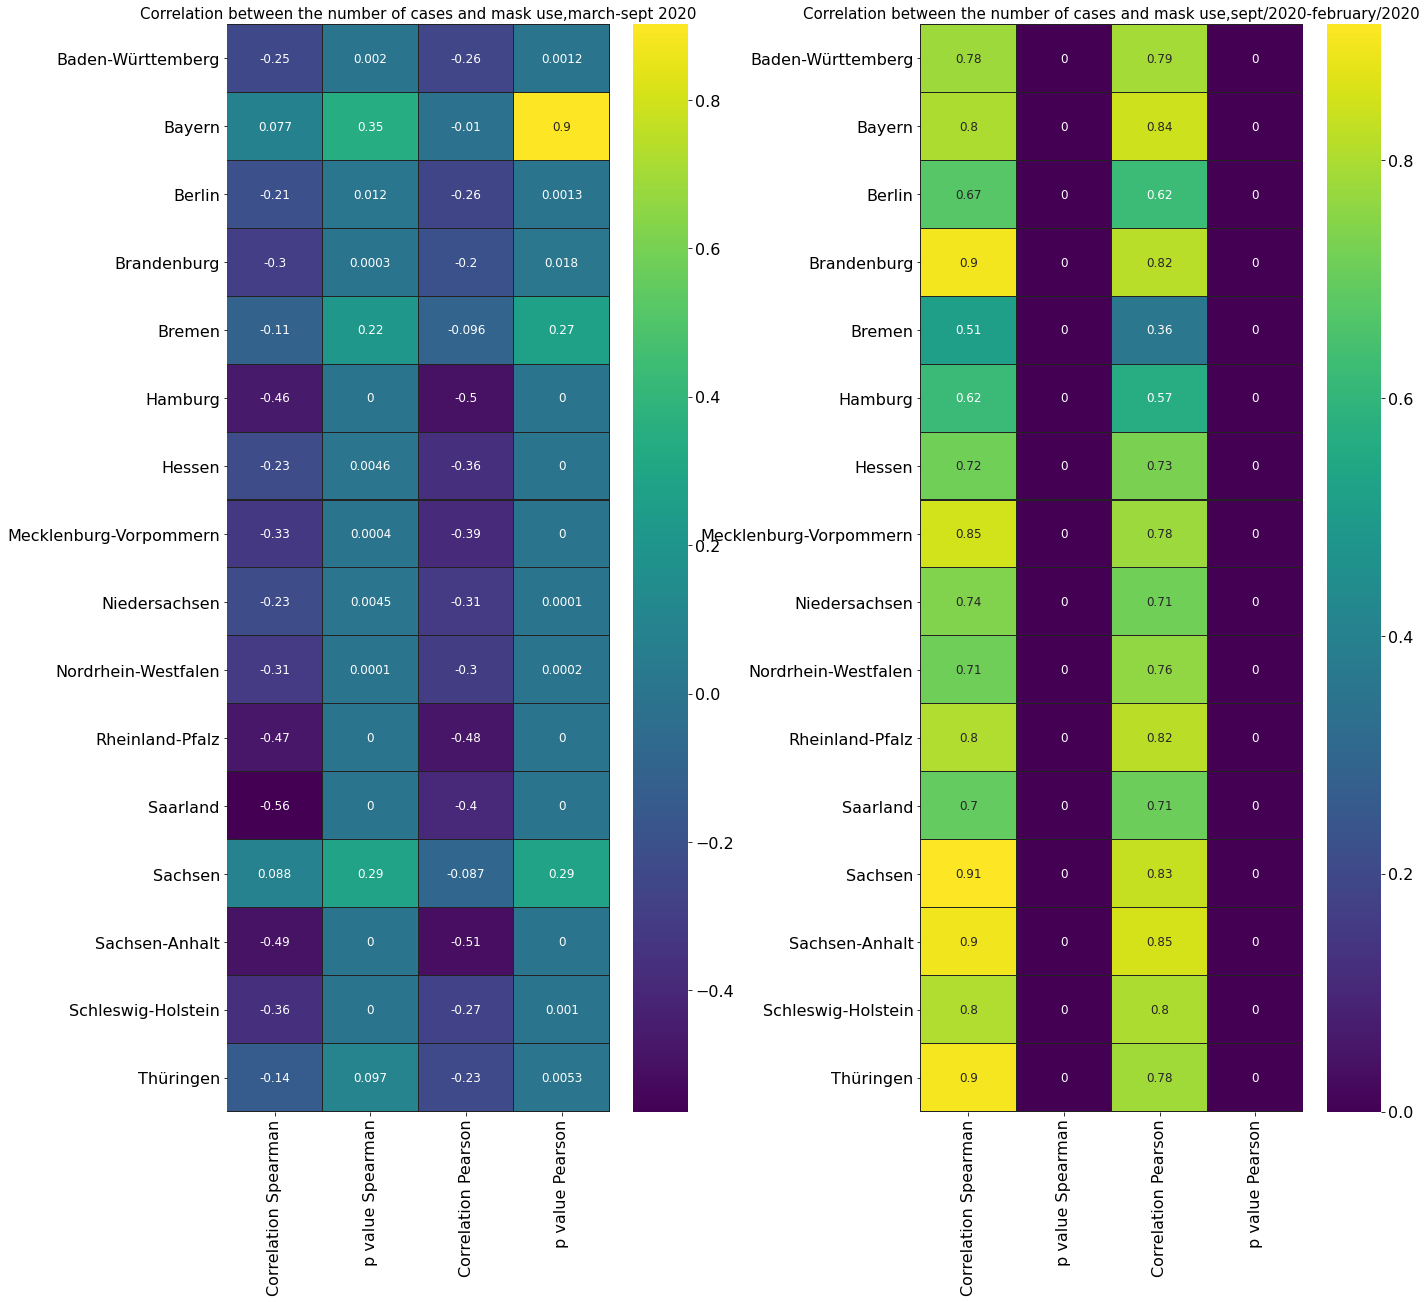

In [11]:
# Source:https://covid19.healthdata.org/germany/thuringia?view=mask-use&tab=trend
# Data generated using https://apps.automeris.io/wpd/

df_reg=data_merged_delay

# Takes the region name and returns the external dataset as pandas daframe
def maskUseInRegion(region_iso):
    """Takes the region name and returns the external dataset as pandas daframe"""
    mask_use = pd.read_csv(f"../data/external/MaskUse/{region_iso}.csv", sep = "\t")
    mask_use.columns = ["date","Use_percentage"]
    return mask_use

# Takes the region name,begining data and end date and returns a daframe 
# with corona and weather data only for that region
def mergedDatasetInRegion(region_name,begining_date,end_date):
    """Takes the region name,begining data and end date and returns a daframe with corona and weather data only for that region"""
    data_merged_1=data_merged_delay.loc[data_merged_delay["region_code"]==region_name]
    mask = (data_merged_1['date'] > begining_date) & (data_merged_1['date'] <= end_date)
    data_merged_1= data_merged_1.loc[mask]
    data_merged_1['date'] = data_merged_1['date'].dt.strftime('%Y-%m-%d')
    return data_merged_1

# Takes the dataframe with correlations and p-values and creates a heatmap
def createHeatmapCorr(ax,dataframe):
    """Takes the dataframe with correlations and p-values and creates a heatmap"""
    sns.heatmap(dataframe, annot=True,ax=ax,cmap="viridis",linewidth=0.01,linecolor="#222",annot_kws={'fontsize':12})

# Finds the Pearson and Spearman correlation and p_values between the number of cases and 
# use percentage, in this case. Returns a dataframe with correlations and pvalues    
def corrFunction(begining_date,end_date):
    """Finds the Pearson and Spearman correlation and p_values between the number of cases and Use percentage,in this case
    Returns a dataframe with correlations and pvalues"""
    corr_list=[]
    pvalue_list=[]
    corr_list_pearson=[]
    pvalue_list_pearson=[]
    for p in region_dic.items():
        data_merged_x = pd.merge(mergedDatasetInRegion(p[1],begining_date,end_date),maskUseInRegion(p[0]),how='inner',on="date")
        corr, pvalue = spearmanr(data_merged_x["CASES"], data_merged_x["Use_percentage"])
        corr1,pvalue1 = pearsonr(data_merged_x["CASES"], data_merged_x["Use_percentage"])
        corr_list.append(corr)
        pvalue_list.append(round(pvalue,4))
        corr_list_pearson.append(corr1)
        pvalue_list_pearson.append(round(pvalue1,4))
    data_corr_pvalue = {
        'Correlation Spearman': corr_list,
        "p value Spearman": pvalue_list,
        "Correlation Pearson":corr_list_pearson,
        "p value Pearson": pvalue_list_pearson
        }
    df_corr_pvalue = pd.DataFrame(data_corr_pvalue, columns = ["Correlation Spearman","p value Spearman","Correlation Pearson","p value Pearson"],index = Index)
    return df_corr_pvalue

# Creating a dataframe with the mask used added to the weather data and the coroana data
def getDf(begining_date,end_date):
    """Creating a dataframe with the mask used added to the weather data and the coroana data"""
    for p in region_dic.items():
        data_merged_x = pd.merge(mergedDatasetInRegion(p[1],begining_date,end_date),maskUseInRegion(p[0]),how='inner',on="date")
        corr, pvalue = spearmanr(data_merged_x["CASES"], data_merged_x["Use_percentage"])
        corr1,pvalue1 = pearsonr(data_merged_x["CASES"], data_merged_x["Use_percentage"])
        if(p[0]=="DE-BW"):
            df_reg = data_merged_x
        else:
            df_reg = df_reg.append(data_merged_x)
    return df_reg

# Plotting the heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21,20))
createHeatmapCorr(ax1,corrFunction('2020-02-01',"2020-09-01"))
createHeatmapCorr(ax2,corrFunction('2020-09-01',"2021-02-01"))
ax1.set_title('Correlation between the number of cases and mask use,march-sept 2020',fontsize=15)
ax2.set_title('Correlation between the number of cases and mask use,sept/2020-february/2020',fontsize=15)
plt.subplots_adjust( wspace=0.45)
plt.show()

In [12]:
df_reg=getDf('2020-02-01',"2021-02-01")
df_reg

,date,region_code,CASES,deaths,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Use_percentage
0,2020-03-02,Baden-Württemberg,1,0,80.314208,6.604918e+05,2.308155e+06,8.744530,0.005284,0.467799,4.663207,0.828704
1,2020-03-03,Baden-Württemberg,2,0,78.675310,7.231482e+05,2.276181e+06,6.627256,0.008104,0.435906,6.260114,1.065172
2,2020-03-05,Baden-Württemberg,3,0,83.948059,7.570487e+05,2.271955e+06,1.241182,0.012448,0.515311,6.175576,1.391074
3,2020-03-06,Baden-Württemberg,7,0,67.196807,6.612446e+06,2.303111e+06,2.829675,0.001052,0.787767,4.434665,1.706955
4,2020-03-07,Baden-Württemberg,2,0,69.740370,4.022420e+06,2.271215e+06,7.605364,0.006413,0.726677,4.874364,2.221749
...,...,...,...,...,...,...,...,...,...,...,...,...
262,2021-01-28,Thüringen,763,34,69.900549,1.795976e+06,2.291394e+06,6.316904,0.001476,0.071083,7.011695,52.266670
263,2021-01-29,Thüringen,676,18,84.561938,3.806691e+05,2.283500e+06,4.490212,0.004488,0.003885,5.104849,52.118308
264,2021-01-30,Thüringen,492,21,90.979262,5.069665e+05,2.288794e+06,0.648044,0.005692,0.017127,2.919355,51.940072
265,2021-01-31,Thüringen,229,5,90.285177,9.239736e+04,2.286934e+06,-0.145420,0.006211,0.004797,3.627331,51.761835


In [13]:
# Getting the variable that we want to use for regresssion
Xs = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround', 'UVIndex',"Use_percentage",
      "Totalprecipitation","WindSpeed"]

# Creating significance threshold taking into consideration the number of variable used
significance_threshold = 0.001 / (len(Xs) * 3)

# Adding the constant
df_reg = sm.add_constant(df_reg)
Xs.append("const")

In [14]:
# Linear regression on between the number of cases and the variable stated in Xs list
est = sm.OLS(df_reg["CASES"], df_reg[Xs], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  CASES   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     282.8
Date:                Sun, 21 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:51:33   Log-Likelihood:                -34169.
No. Observations:                4302   AIC:                         6.836e+04
Df Residuals:                    4293   BIC:                         6.841e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [15]:
# Linear regression using logarithms
est = sm.OLS(np.log(df_reg["CASES"]), df_reg[Xs], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  CASES   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     723.5
Date:                Sun, 21 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:51:44   Log-Likelihood:                -7449.7
No. Observations:                4302   AIC:                         1.492e+04
Df Residuals:                    4293   BIC:                         1.497e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   